Device: cuda


[Epoch 1] train_loss=0.1780 train_acc=0.9254 val_loss=0.0482 val_acc=0.9696
Saved best model to best_model.pt


[Epoch 2] train_loss=0.0452 train_acc=0.9854 val_loss=0.0331 val_acc=0.9772
Saved best model to best_model.pt


[Epoch 3] train_loss=0.0286 train_acc=0.9913 val_loss=0.0294 val_acc=0.9848
Saved best model to best_model.pt


[Epoch 4] train_loss=0.0202 train_acc=0.9930 val_loss=0.0277 val_acc=0.9886
Saved best model to best_model.pt


[Epoch 5] train_loss=0.0164 train_acc=0.9943 val_loss=0.0305 val_acc=0.9886


[Epoch 6] train_loss=0.0131 train_acc=0.9957 val_loss=0.0381 val_acc=0.9867


[Epoch 7] train_loss=0.0120 train_acc=0.9954 val_loss=0.0338 val_acc=0.9867


[Epoch 8] train_loss=0.0124 train_acc=0.9954 val_loss=0.0378 val_acc=0.9867


[Epoch 9] train_loss=0.0093 train_acc=0.9978 val_loss=0.0306 val_acc=0.9867


[Epoch 10] train_loss=0.0110 train_acc=0.9970 val_loss=0.0300 val_acc=0.9886


[Epoch 11] train_loss=0.0054 train_acc=0.9984 val_loss=0.0372 val_acc=0.9848


[Epoch 12] train_loss=0.0059 train_acc=0.9973 val_loss=0.0359 val_acc=0.9867


[Epoch 13] train_loss=0.0055 train_acc=0.9981 val_loss=0.0275 val_acc=0.9867


[Epoch 14] train_loss=0.0069 train_acc=0.9978 val_loss=0.0354 val_acc=0.9867


[Epoch 15] train_loss=0.0051 train_acc=0.9984 val_loss=0.0272 val_acc=0.9924
Validation report:
               precision    recall  f1-score   support

     malware     0.9962    0.9888    0.9925       267
  ransomware     0.9885    0.9961    0.9923       259

    accuracy                         0.9924       526
   macro avg     0.9924    0.9925    0.9924       526
weighted avg     0.9924    0.9924    0.9924       526

Saved best model to best_model.pt



=== FINAL TEST ===
test_loss=0.0421 test_acc=0.9934
Test report:
               precision    recall  f1-score   support

     malware     0.9944    0.9926    0.9935       537
  ransomware     0.9923    0.9942    0.9932       516

    accuracy                         0.9934      1053
   macro avg     0.9933    0.9934    0.9933      1053
weighted avg     0.9934    0.9934    0.9934      1053



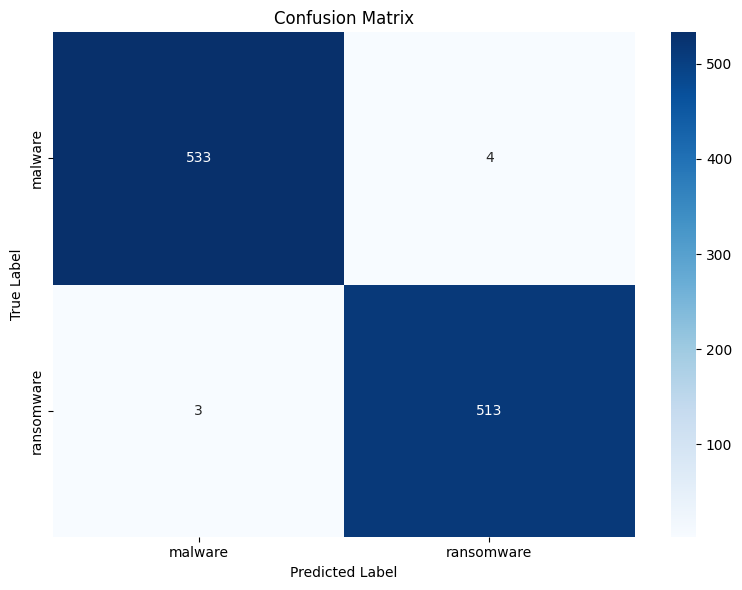

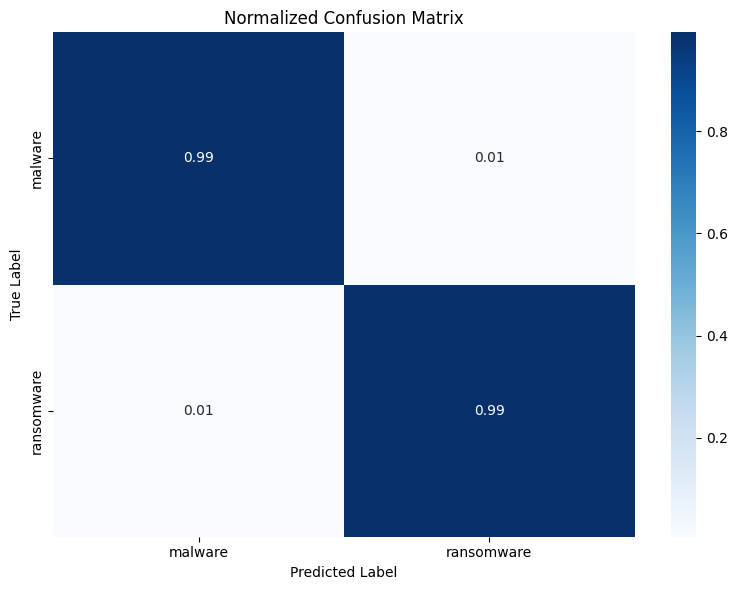

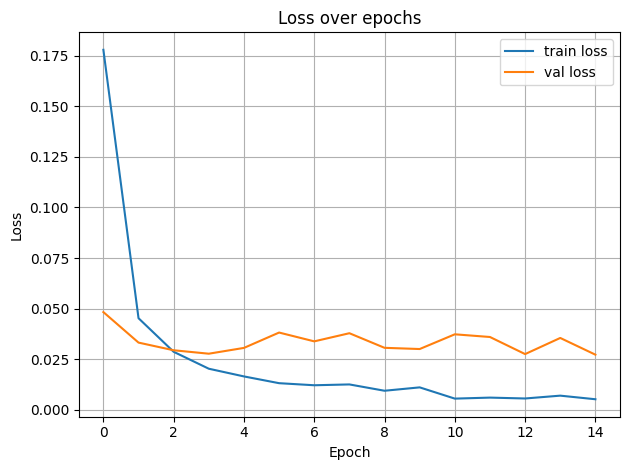

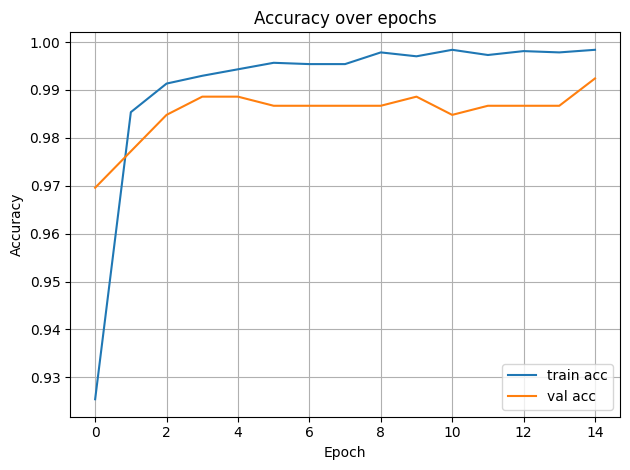

In [2]:
#!/usr/bin/env python3
"""
1D CNN Malware vs Ransomware classifier with opcode + API fusion.
Includes confusion matrix plotting using seaborn.
"""

import os
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuration
config = {
    "malware_csv": "./mw_ghidra_filtered.csv",
    "ransomware_csv": "./rw_ghidra_filtered.csv",
    "epochs": 15,
    "batch_size": 64,
    "opcode_embed_dim": 64,
    "api_embed_dim": 64,
    "conv_out": 64,
    "fc_hidden": 64,
    "opcode_kernel_sizes": (3, 5, 7),
    "api_kernel_sizes": (3, 5, 7),
    "dropout": 0.3,
    "max_opcode_len": 400,
    "max_api_len": 400,
    "val_frac": 0.1,
    "test_frac": 0.2,
    "seed": 42,
    "use_gpu": True,
    "save_model_path": "best_model.pt", 
    "verbose": True,
    "threshold": 0.5,
}

# Encoding
class Vocab:
    def __init__(self, min_freq=1, reserved_tokens=None):
        self.counter = Counter()
        self.min_freq = min_freq
        self.reserved_tokens = reserved_tokens if reserved_tokens else []
        self.token2idx = {}
        self.idx2token = []
        self.unk_token = "<UNK>"
        self.pad_token = "<PAD>"

    def build(self, sequences):
        for seq in sequences:
            self.counter.update(seq)
        tokens = [self.pad_token, self.unk_token] + self.reserved_tokens
        for token, freq in self.counter.most_common():
            if freq < self.min_freq:
                continue
            if token in tokens:
                continue
            tokens.append(token)
        self.idx2token = tokens
        self.token2idx = {t: i for i, t in enumerate(self.idx2token)}

    def encode(self, sequence):
        return [self.token2idx.get(t, self.token2idx[self.unk_token]) for t in sequence]

    def __len__(self):
        return len(self.idx2token)

# Dataset Preprocessing
def preprocess_opcode_seq(raw: str):
    return raw.strip().lower().split()

def preprocess_api_seq(raw: str):
    return [a.strip() for a in raw.strip().split(";") if a.strip()]

# Dataset Preparation and Encoding
class MalwareRansomDataset(Dataset):
    def __init__(self, malware_csv, ransomware_csv,
                 opcode_vocab=None, api_vocab=None,
                 max_opcode_len=400, max_api_len=400):
        df_mal = pd.read_csv(malware_csv, header=None, names=["filename", "opcodes", "apis"])
        df_ran = pd.read_csv(ransomware_csv, header=None, names=["filename", "opcodes", "apis"])
        self.samples = []
        for _, row in df_mal.iterrows():
            self.samples.append({
                "op": preprocess_opcode_seq(row["opcodes"]),
                "api": preprocess_api_seq(row["apis"]),
                "label": 0
            })
        for _, row in df_ran.iterrows():
            self.samples.append({
                "op": preprocess_opcode_seq(row["opcodes"]),
                "api": preprocess_api_seq(row["apis"]),
                "label": 1
            })
        all_op_seqs = [s["op"] for s in self.samples]
        all_api_seqs = [s["api"] for s in self.samples]
        if opcode_vocab is None:
            self.opcode_vocab = Vocab(min_freq=1)
            self.opcode_vocab.build(all_op_seqs)
        else:
            self.opcode_vocab = opcode_vocab
        if api_vocab is None:
            self.api_vocab = Vocab(min_freq=1)
            self.api_vocab.build(all_api_seqs)
        else:
            self.api_vocab = api_vocab

        self.max_opcode_len = max_opcode_len
        self.max_api_len = max_api_len

    def pad_and_truncate(self, seq_idx, max_len):
        if len(seq_idx) >= max_len:
            return seq_idx[:max_len]
        return seq_idx + [0] * (max_len - len(seq_idx))  # pad index 0 is <PAD>

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        op_encoded = self.opcode_vocab.encode(entry["op"])
        api_encoded = self.api_vocab.encode(entry["api"])
        op_padded = self.pad_and_truncate(op_encoded, self.max_opcode_len)
        api_padded = self.pad_and_truncate(api_encoded, self.max_api_len)
        return {
            "op": torch.tensor(op_padded, dtype=torch.long),
            "api": torch.tensor(api_padded, dtype=torch.long),
            "label": torch.tensor(entry["label"], dtype=torch.float)
        }

# Feature Extraction
class Conv1DBlock(nn.Module):
    def __init__(self, emb_dim, out_channels, kernel_sizes, dropout=0.2):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=k)
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, embedded):
        # embedded: [B, L, E]
        x = embedded.transpose(1, 2)  # -> [B, E, L]
        conv_outs = [F.relu(conv(x)) for conv in self.convs]  # list of [B, C, L-k+1]
        pooled = [F.adaptive_max_pool1d(o, 1).squeeze(-1) for o in conv_outs]  # [B, C]
        cat = torch.cat(pooled, dim=1)  # [B, C * num_kernels]
        return self.dropout(cat)

# Classification Layer
class MalwareRansomClassifier(nn.Module):
    def __init__(self,
                 opcode_vocab_size, api_vocab_size,
                 opcode_embed_dim=64, api_embed_dim=64,
                 conv_out=64, fc_hidden=64,
                 opcode_kernel_sizes=(3,5,7), api_kernel_sizes=(1,3,5),
                 dropout=0.3):
        super().__init__()
        self.op_embed = nn.Embedding(opcode_vocab_size, opcode_embed_dim, padding_idx=0)
        self.api_embed = nn.Embedding(api_vocab_size, api_embed_dim, padding_idx=0)
        self.op_conv = Conv1DBlock(opcode_embed_dim, conv_out, kernel_sizes=opcode_kernel_sizes, dropout=dropout)
        self.api_conv = Conv1DBlock(api_embed_dim, conv_out, kernel_sizes=api_kernel_sizes, dropout=dropout)
        combined_dim = conv_out * (len(opcode_kernel_sizes) + len(api_kernel_sizes))
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, fc_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, op_seq, api_seq):
        op_emb = self.op_embed(op_seq)
        api_emb = self.api_embed(api_seq)
        op_repr = self.op_conv(op_emb)
        api_repr = self.api_conv(api_emb)
        combined = torch.cat([op_repr, api_repr], dim=1)
        out = self.classifier(combined).squeeze(1)
        return out

# Training and Evaluation
def set_seed(seed=41):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    losses = []
    all_preds = []
    all_labels = []
    for batch in tqdm(dataloader, desc="Train", leave=False):
        op = batch["op"].to(device)
        api = batch["api"].to(device)
        label = batch["label"].to(device)
        optimizer.zero_grad()
        output = model(op, api)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        preds = (output.detach().cpu().numpy() >= config["threshold"]).astype(int).tolist()
        all_preds.extend(preds)
        all_labels.extend(label.detach().cpu().numpy().astype(int).tolist())
    acc = accuracy_score(all_labels, all_preds)
    return np.mean(losses), acc

def eval_one_epoch(model, dataloader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval", leave=False):
            op = batch["op"].to(device)
            api = batch["api"].to(device)
            label = batch["label"].to(device)
            output = model(op, api)
            loss = criterion(output, label)
            losses.append(loss.item())
            prob = output.detach().cpu().numpy()
            all_probs.extend(prob.tolist())
            preds = (prob >= config["threshold"]).astype(int).tolist()
            all_preds.extend(preds)
            all_labels.extend(label.detach().cpu().numpy().astype(int).tolist())
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4, target_names=["malware", "ransomware"])
    return np.mean(losses), acc, report, all_labels, all_preds, all_probs

def plot_confusion_matrix(trues, preds, classes=("malware", "ransomware"), normalize=False):
    cm = confusion_matrix(trues, preds)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
        title = "Normalized Confusion Matrix"
    else:
        fmt = "d"
        title = "Confusion Matrix"

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ----------------------- run -----------------------
def run(cfg):
    set_seed(cfg["seed"])
    device = torch.device("cuda" if (torch.cuda.is_available() and cfg["use_gpu"]) else "cpu")
    print("Device:", device)

    dataset = MalwareRansomDataset(
        malware_csv=cfg["malware_csv"],
        ransomware_csv=cfg["ransomware_csv"],
        max_opcode_len=cfg["max_opcode_len"],
        max_api_len=cfg["max_api_len"],
    )
    total = len(dataset)
    val_size = int(total * cfg["val_frac"])
    test_size = int(total * cfg["test_frac"])
    train_size = total - val_size - test_size
    train_ds, val_ds, test_ds = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(0)
    )
    train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg["batch_size"], shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=cfg["batch_size"], shuffle=False)

    model = MalwareRansomClassifier(
        opcode_vocab_size=len(dataset.opcode_vocab),
        api_vocab_size=len(dataset.api_vocab),
        opcode_embed_dim=cfg["opcode_embed_dim"],
        api_embed_dim=cfg["api_embed_dim"],
        conv_out=cfg["conv_out"],
        fc_hidden=cfg["fc_hidden"],
        opcode_kernel_sizes=cfg["opcode_kernel_sizes"],
        api_kernel_sizes=cfg["api_kernel_sizes"],
        dropout=cfg["dropout"],
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_acc = 0.0

    for epoch in range(1, cfg["epochs"] + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc, val_report, _, _, _ = eval_one_epoch(model, val_loader, criterion, device)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
              f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")
        if cfg["verbose"] and epoch == cfg["epochs"]:
            print("Validation report:\n", val_report)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            if cfg["save_model_path"]:
                torch.save({
                    "model_state": model.state_dict(),
                    "opcode_vocab": dataset.opcode_vocab.token2idx,
                    "api_vocab": dataset.api_vocab.token2idx,
                }, cfg["save_model_path"])
                print(f"Saved best model to {cfg['save_model_path']}")

    # final test
    test_loss, test_acc, test_report, trues, preds, probs = eval_one_epoch(model, test_loader, criterion, device)
    print("\n=== FINAL TEST ===")
    print(f"test_loss={test_loss:.4f} test_acc={test_acc:.4f}")
    print("Test report:\n", test_report)

    # confusion matrices
    plot_confusion_matrix(trues, preds, normalize=False)
    plot_confusion_matrix(trues, preds, normalize=True)

    # loss/accuracy curves
    plt.figure()
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model, dataset, history

if __name__ == "__main__":
    run(config)
